### Part - I: Importing Required Modules/ Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf 
import keras
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)

2.6.0
2.6.0
1.3.4
1.19.5


In [2]:
# custom declarations 
from nn_globals import *
from dataset import muon_data_split

### Part- II: Data Preprocessing

In [4]:
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ =  muon_data_split(filename = DATAFILEPATH, 
                                                                                                                reg_pt_scale=REG_PT_SCALE, 
                                                                                                                reg_dxy_scale=REG_DXY_SCALE, 
                                                                                                                test_size=TEST_SIZE,
                                                                                                                nvariables = NVARIABLES,
                                                                                                                nentries = NENTRIES)

[INFO    ] Loading muon data from ./data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


### Part-III: Use the cells in this section for data exploration

In [ ]:
# cols = ["dphi_1","dphi_2","dphi_3","dphi_4","dphi_5","dphi_6",
#        "dtheta_1","dtheta_2","dtheta_3","dtheta_4","dtheta_5", "dtheta_6",
#        "bend_1","bend_2","bend_3","bend_4",
#        "track theta"]

# x = np.concatenate((x_train_displ,x_test_displ),axis=0)
# y = np.concatenate((y_train_displ,y_test_displ),axis=0)
# dxy = np.concatenate((dxy_train_displ,dxy_test_displ),axis=0)

# corr_plot(x,y,dxy,columns = cols)

### Part- III: Load and Account the Perf for the Baseline

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, TerminateOnNaN, EarlyStopping

# project-specific imports
from nn_evaluate import huber_loss, k_fold_validation
from nn_training import lr_schedule
from nn_pruning_module_support import loading_trained_model
from nn_training import train_model
from nn_training_pruned_model import (generate_layer_masks, 
                                      create_sparse_model)
from nn_plotting import __generate_delta_plots__

In [7]:
baseline = loading_trained_model(filepath = "./models/",
                                 model_filename = "model")
baseline.summary()

./models//model.json
./models//model_weights.h5
Metal device set to: Apple M1
Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 23)                92        
_________________________________________________________________
dense (Dense)                (None, 20)                460       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                300       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_____________________

2022-01-11 11:15:13.748331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-11 11:15:13.748460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-01-11 11:15:16.538293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-11 11:15:16.538804: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-11 11:15:16.589100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean MAE for 1-Fold cv for momentum = 10.805401013892237
Mean MAE for 1-Fold cv for displacement = 11.09470082119601
Mean RMSE for 1-Fold cv for momentum = 51.61877535408888
Mean RMSE for 1-Fold cv for displacement = 15.895834550414392


[INFO    ] # of entries: 1034656, mean: 0.0450265648079865, std: 0.18056006751758544
[INFO    ] gaus fit (a, mu, sig): [5.93053392e+04 2.59689338e-03 2.27387447e-01]


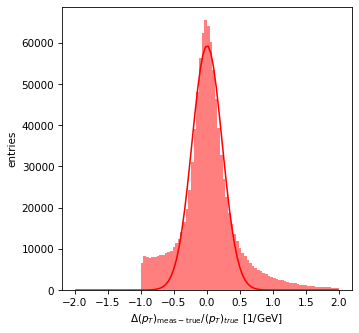

[INFO    ] # of entries: 150253, mean: 0.05408358332716961, std: 10.000876111176593
[INFO    ] gaus fit (a, mu, sig): [ 1.01955829e+04 -1.97576655e-02  5.25735096e+00]


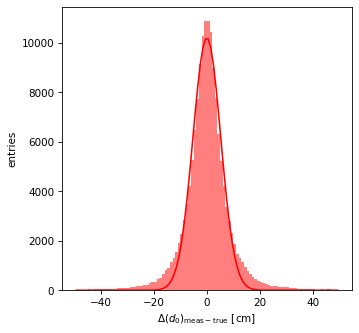

In [8]:
# Quantitative Evaluation
k_fold_validation(model = baseline, 
          x = x_test_displ, 
          y = y_test_displ, 
          dxy = dxy_test_displ, 
          folds =1,
          metric_type = "MAE")    
k_fold_validation(model = baseline, 
          x = x_test_displ, 
          y = y_test_displ, 
          dxy = dxy_test_displ, 
          folds =1,
          metric_type = "RMSE")   

# Qualitative Evaluation:
__generate_delta_plots__(model = baseline,
                          x = x_test_displ,
                          y = y_test_displ,
                          dxy = dxy_test_displ,
                          color = "red",
                         alpha = 0.5)

### Part-IV: Build the custom model

In [ ]:
# def run_iterative_pruning(baseline_model = None,
#                           target_sparsity: float = 0.1, 
#                           pruning_fraction_step:float = 0.1,
#                           training_params: list = []):
    
#     if target_sparsity > 1.0 or target_sparsity <= 0:
#         print("INVALID value entered for target sparsity, it can only be in the range [0,1]")
#     if pruning_fraction_step > target_sparsity:
#         print("INVALID value entered for pruning fraction, it has to be <= target_sparsity")
    
#     # list of models, new pruned models get appended to it while training
#     pruned_models, training_history = [],[]
#     plot_colors = ["red","orange","blue","cyan","purple","green","magenta", "salmon"]
#     init_sparsity = pruning_fraction_step
#     i = 0
#     while(init_sparsity <= target_sparsity):

#         print("-----------------------------------------------------------------------------------------------")
#         print("-----------------------------------------------------------------------------------------------")
#         print("Currently pruning the model upto {} % of the baseline".format(round(init_sparsity*100)))
#         print("-----------------------------------------------------------------------------------------------")
#         print("-----------------------------------------------------------------------------------------------")

#         x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ =  muon_data_split(infile_muon_displ, 
#                                                                                                                        reg_pt_scale=reg_pt_scale, 
#                                                                                                                        reg_dxy_scale=reg_dxy_scale, 
#                                                                                                                        test_size=0.315)
#         y_train_displ = np.abs(y_train_displ)
#         y_test_displ = np.abs(y_test_displ)

#         # training loop begins
#         lr = training_params[i]['lr']
#         clipnorm = training_params[i]['clipnorm']
#         eps = training_params[i]['eps']
#         momentum = training_params[i]['momentum']
#         retrain_epochs = training_params[i]['epochs']
#         retrain_batch_size = training_params[i]['batch_size']
#         l1_reg = training_params[i]['l1_reg']
#         l2_reg = training_params[i]['l2_reg']
#         sparsity = init_sparsity
        
#         # define optimizer, callbacks here
#         adam = Adam(lr=lr, clipnorm=clipnorm)
#         lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
#         terminate_on_nan = TerminateOnNaN()
#         early_stopping = EarlyStopping(monitor='val_loss', 
#                                        min_delta=1e-5, 
#                                        patience=40, 
#                                        verbose=True,
#                                        mode='min')
#         curr_model = None
#         if len(pruned_models) == 0:
#             curr_model = baseline_model
#         else:
#             curr_model = pruned_models[-1]

#         pruned_model = create_sparse_model(model = curr_model,
#                                                input_dim = nvariables,
#                                                output_dim = 2,
#                                                k_sparsity = sparsity,
#                                                bn_epsilon = eps,
#                                                bn_momentum = momentum,
#                                                l1_reg = l1_reg,
#                                                l2_reg = l1_reg,
#                                                kernel_initializer="glorot_uniform",
#                                                optimizer = adam)

#         pruned_model, history = train_model(model = pruned_model,
#                                             x = x_train_displ,
#                                             y = np.column_stack((y_train_displ, dxy_train_displ)),
#                                             epochs = retrain_epochs,
#                                             batch_size = retrain_batch_size,
#                                             callbacks=[lr_decay, 
#                                                       early_stopping, 
#                                                       terminate_on_nan],
#                                             verbose = True,
#                                             validation_split=0.1)
        
#         # evaluate the model
#         k_fold_validation(model = pruned_model, 
#                   x = x_test_displ, 
#                   y = y_test_displ, 
#                   dxy = dxy_test_displ, 
#                   folds =1,
#                   metric_type = "MAE")    
#         k_fold_validation(model = pruned_model, 
#                   x = x_test_displ, 
#                   y = y_test_displ, 
#                   dxy = dxy_test_displ, 
#                   folds =1,
#                   metric_type = "RMSE")   

#         __generate_delta_plots__(model = pruned_model,
#                                  x = x_test_displ,
#                                  y = y_test_displ,
#                                  dxy = dxy_test_displ,
#                                  color = plot_colors[i])
        
#         pruned_models.append(pruned_model)
#         training_history.append(history)

#         # training ends
#         i += 1
#         init_sparsity += pruning_fraction_step
    
#     return pruned_models, training_history

In [ ]:
from typing import List, Union
def run_iterative_pruning_v2 (X_train ,
                              y_train ,
                              dxy_train ,
                              X_test ,
                              y_test ,
                              dxy_test ,
                              baseline_model,
                              pruning_type:str = "unstructured",
                              init_sparsity: float = 0.1 ,
                              target_sparsity: float = 1.0 ,
                              pruning_fraction_step: float = 0.1 ,
                              training_params: List[dict] = None ,
                              cv_folds: int = 1 ,
                              plot_colors: Union[str,List[str],None] = "red") :
    if target_sparsity > 1.0 or target_sparsity <= 0 :
        print ("INVALID value entered for target sparsity, it can only be in the range [0,1]")
    if pruning_fraction_step > target_sparsity :
        print ("INVALID value entered for pruning fraction, it has to be <= target_sparsity")

    # list of models, new pruned models get appended to it while training
    pruned_models , training_historys = [] , []
    i = 0
    while (init_sparsity <= target_sparsity) :

        print ("-----------------------------------------------------------------------------------------------")
        print ("-----------------------------------------------------------------------------------------------")
        print ("Currently pruning the model upto {} % of the baseline".format (round (init_sparsity * 100)))
        print ("-----------------------------------------------------------------------------------------------")
        print ("-----------------------------------------------------------------------------------------------")

        # training loop begins
        lr = training_params [i] ['lr']
        clipnorm = training_params [i] ['clipnorm']
        eps = training_params [i] ['eps']
        momentum = training_params [i] ['momentum']
        retrain_epochs = training_params [i] ['epochs']
        retrain_batch_size = training_params [i] ['batch_size']
        l1_reg = training_params [i] ['l1_reg']
        l2_reg = training_params [i] ['l2_reg']
        sparsity = init_sparsity

        # define optimizer, callbacks here
        adam = Adam (lr=lr , clipnorm=clipnorm)
        lr_decay = LearningRateScheduler (lr_schedule , verbose=1)
        terminate_on_nan = TerminateOnNaN ()
        early_stopping = EarlyStopping (min_delta=1e-5 ,
                                        monitor='val_loss' ,
                                        patience=10 ,
                                        verbose=True ,
                                        mode='auto')
        curr_model = None
        if len (pruned_models) == 0 :
            curr_model = baseline_model
        else :
            curr_model = pruned_models [-1]

        pruned_model = create_sparse_model (model=curr_model ,
                                            input_dim=NVARIABLES ,
                                            output_dim=2 ,
                                            k_sparsity=sparsity ,
                                            pruning_type=pruning_type,
                                            bn_epsilon=eps ,
                                            bn_momentum=momentum ,
                                            l1_reg=l1_reg ,
                                            l2_reg=l1_reg ,
                                            kernel_initializer="glorot_uniform",
                                            optimizer=adam)

        pruned_model , history = train_model (model=pruned_model ,
                                              x=X_train ,
                                              y=np.column_stack ((y_train , dxy_train)) ,
                                              epochs=retrain_epochs ,
                                              batch_size=retrain_batch_size ,
                                              callbacks=[lr_decay ,
                                                         early_stopping ,
                                                         terminate_on_nan] ,
                                              verbose=True ,
                                              validation_split=0.1)

        k_fold_validation (model=pruned_model ,
                           x=X_test ,
                           y=y_test ,
                           dxy=dxy_test ,
                           folds=cv_folds ,
                           metric_type="MAE")
        k_fold_validation (model=pruned_model ,
                           x=X_test ,
                           y=y_test ,
                           dxy=dxy_test ,
                           folds=cv_folds ,
                           metric_type="RMSE")
        if isinstance(plot_colors, list):
            plot_color = plot_colors[i]
        else:
            plot_color = plot_colors
        __generate_delta_plots__ (model=pruned_model ,
                                  x=X_test ,
                                  y=y_test ,
                                  dxy=dxy_test ,
                                  color=plot_color,
                                  bins_y = [-3.,3.],
                                  bins_dxy = [-75.,75.])

        pruned_models.append (pruned_model)
        training_historys.append (history)

        # training ends
        i += 1
        init_sparsity += pruning_fraction_step

    return pruned_models , training_historys

In [ ]:
# ft_params = [
#         {
#         "lr": 1e-4,
#         "clipnorm": 100.,
#         "eps": 1e-4,
#         "momentum": 0.9,
#         "epochs": 50,
#         "batch_size": 1000,
#         "l1_reg": 0.0,
#         "l2_reg": 0.0
#     }]

ft_params = [
        {
        "lr": 5e-3,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]
pruned_model_10, training_history_10 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = baseline,
                                                                init_sparsity = 0.1,
                                                                target_sparsity = 0.1,
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "salmon")


In [ ]:
# ft_params = [
#     {
#         "lr": 1e-3,
#         "clipnorm": 100.,
#         "eps": 1e-4,
#         "momentum": 0.8,
#         "epochs": 75,
#         "batch_size": 1000,
#         "l1_reg": 0.0,
#         "l2_reg": 0.0
#     }]
ft_params = [
        {
        "lr": 6e-3,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]

pruned_model_20, training_history_20 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = pruned_model_10[0],
                                                                init_sparsity = 0.2,
                                                                target_sparsity = 0.2,
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "plum")


In [ ]:
ft_params = [
       {
        "lr": 7e-3,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]
pruned_model_30, training_history_30 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = pruned_model_20[0],
                                                                init_sparsity = 0.3,
                                                                target_sparsity = 0.3,
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "green")


In [ ]:
# ft_params = [
#     {
#         "lr": 2.0e-3,
#         "clipnorm": 100.,
#         "eps": 1e-4,
#         "momentum": 0.9,
#         "epochs": 200,
#         "batch_size": 1000,
#         "l1_reg": 0.0,
#         "l2_reg": 0.0
#     }]
ft_params = [
    {
        "lr": 7.5e-3,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]
pruned_model_40, training_history_40 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = pruned_model_30[0],
                                                                init_sparsity = 0.4,
                                                                target_sparsity = 0.4,
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "purple")


In [ ]:
# ft_params = [
#     {
#         "lr": 3.5e-3,
#         "clipnorm": 50.,
#         "eps": 1e-4,
#         "momentum": 0.9,
#         "epochs": 250,
#         "batch_size": 1000,
#         "l1_reg": 0.0,
#         "l2_reg": 0.0
#     }]
ft_params = [
    {
        "lr": 7e-3,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]
pruned_model_50, training_history_50 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = pruned_model_40[0],
                                                                init_sparsity = 0.5,
                                                                target_sparsity = 0.5,
                                                                # pruning_type = "structured",
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "blue")


In [ ]:
# ft_params = [
#     {
#         "lr": 0.005,
#         "clipnorm": 100.,
#         "eps": 1e-4,
#         "momentum": 0.9,
#         "epochs": 300,
#         "batch_size": 1000,
#         "l1_reg": 0.0,
#         "l2_reg": 0.0
#     }]
ft_params = [
    {
        "lr": 7.5e-3,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]
pruned_model_60, training_history_60 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = pruned_model_50[0],
                                                                init_sparsity = 0.6,
                                                                target_sparsity = 0.6,
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "orange")


In [ ]:
ft_params = [
    {
        "lr": 1e-2,
        "clipnorm": 100.,
        "eps": 1e-4,
        "momentum": 0.9,
        "epochs": 250,
        "batch_size": 1000,
        "l1_reg": 0.0,
        "l2_reg": 0.0
    }]
pruned_model_70, training_history_70 = run_iterative_pruning_v2(x_train_displ, y_train_displ, dxy_train_displ,
                                                                x_test_displ, y_test_displ, dxy_test_displ,
                                                                baseline_model = pruned_model_60[0],
                                                                init_sparsity = 0.7,
                                                                target_sparsity = 0.7,
                                                                pruning_fraction_step = 0.1,
                                                                training_params = ft_params,
                                                                cv_folds = 1,
                                                                plot_colors = "turquoise")

### Part- V: Saving and Loading the Trained Model

In [ ]:
pruned_models = [pruned_model_10[0],
                 pruned_model_20[0],
                 pruned_model_30[0],
                 pruned_model_40[0],
                 pruned_model_50[0],
                 pruned_model_60[0], 
                 pruned_model_70[0]]
training_history = [training_history_10[0],
                    training_history_20[0],
                    training_history_30[0],
                    training_history_40[0],
                    training_history_50[0],
                    training_history_60[0], 
                    training_history_70[0]]

In [ ]:
import pickle
from nn_pruning_module_support import saving_model
for i in range(len(pruned_models)):
    j = (i+1)*10
    with open(sys.path[-1] +'/' + "trainingLog_US_" + str(j), 'wb') as file_pi:
        pickle.dump(training_history[i].history, file_pi)
    model_filename = "custom_model_US_" + str(j)
    saving_model(model = pruned_models[i], 
                      filepath=  "./models", 
                      model_filename = model_filename)